<img src="https://pbs.twimg.com/profile_images/1901589840/logo-ifmg-betim.jpg" width="700"></img>
<b>Engenharia de Controle e Automação - Redes neurais artificiais</b> - Prof. Leandro Freitas

### Lucas Pevidor Reis - 0024855 - TP3

# 1  Objetivo

Fazer a implementação de uma rede neural multilayer perceptron (MLP) para resolver o problema XOR comentado nas primeiras aulas. Deve ser implementado um algoritmo de retropropagação (backpropagation) manualmente para fazer o ajustes dos pesos e dos bias para uma rede neural estruturada como a seguir:

![MLP](https://i.imgur.com/K998YGR.png)


# 2 Aproximação da função lógica XOR utilizando uma rede neural MLP

## 2.1 Função  a ser estimada:

A função lógica XOR recebe 2 entradas binárias e retorna 0 caso elas sejam iguais, ou 1 caso sejam diferentes, conforme mostrado na tabela abaixo.

![XOR](https://i.imgur.com/wg4Ckhs.png)

Visto que a função não é linearmente separável, é necessário utilizar uma rede neural de múltiplas camadas para realizar sua aproximação. Neste caso, será utilizada uma rede neural de 2 camadas.

## 2.2 Implementação da rede neural

A rede neural foi implementada utilizando classes. A classe neurônio já havia sido implementada nos últimos trabalhos. Foram feitas algumas pequenas modificações, que serão mostradas a seguir. Também foram implementadas as classes Camada e Rede.

### Classe neurônio



In [207]:
import numpy as np
from matplotlib import pyplot as plt

class Neuronio:

    #Função de inicialização da classe
    def __init__(self, n_entradas, func_act, use_bias):
        #Se optar por utilizar bias, será adicionada uma coluna no final dos vetores de entrada com valor unitário.
        self.use_bias = use_bias        
        if use_bias:
            self.pesos = np.empty((n_entradas+1, 1), dtype=float)
        else:
            self.pesos = np.empty((n_entradas, 1), dtype=float)
        self.novosPesos = np.array([])
        self.pesosAnteriores = self.pesos

        self.func_act = func_act
        self.delta = 0        
    
    def reset(self):
        #Fazer pesos randomizados
        vetor = np.ones((len(self.pesos[:,0]), 1), dtype=float)
        for i in range(len(vetor[:,0])):
            vetor[i,0] = np.random.normal(scale=0.3)
        self.pesos = vetor
        self.pesosAnteriores = vetor
        self.novosPesos = np.array([])
    
    @staticmethod
    def fSigmoid(v):
        saida = 1/(1+np.e**(-v))
        return saida
    
    #Definição de entradas
    #Função utilizada para configurar o vetor de entrada interno da classe, juntamente com normalização, adição
    #da coluna de bias. Utilizar quando a média e desvpad para normalização ainda não foram definidos.
    def set_entradas_ant(self, entradas, normalizar):        
        if self.use_bias:
            vetor_1 = np.zeros([len(entradas[:,0]), 1]) + 1
            if normalizar:
                self.normalizar(entradas, False)
                self.vetor_entradas = np.append(self.entr_normalizada, vetor_1, axis=1)
            else:
                self.vetor_entradas = np.append(entradas, vetor_1, axis=1)
        else:
            if normalizar:                
                self.vetor_entradas = self.normalizar(entradas, False)
            else:
                self.vetor_entradas = entradas
    
    #Definir entradas após treinamento da rede
    #Função utilizada para configurar o vetor de entrada interno da classe, juntamente com normalização, adição
    #da coluna de bias. Utilizar quando a média e desvpad para normalização ainda JÁ foram definidos.
    def set_entradas_pós(self, entradas, normalizar):
        if self.use_bias:
            vetor_1 = np.zeros([len(entradas[:,0]), 1]) + 1
            if normalizar:            
                self.vetor_entradas = np.append(self.normalizar(entradas, True), vetor_1, axis=1)
            else:
                self.vetor_entradas = np.append(entradas, vetor_1, axis=1)
        else:
            if normalizar:
                self.vetor_entradas = self.normalizar(entradas, True)
            else:                    
                self.vetor_entradas = entradas
    
    def normalizar(self, entradas, utilizar_parametros_anteriores):
        if utilizar_parametros_anteriores == False:
            #Encontrar média e desvio padrão a partir das entradas fornecidas.
            #Executado antes do treinamento da rede
            self.media = np.empty(len(entradas[0,:]), dtype=float)
            self.desvpad = np.empty(len(entradas[0,:]), dtype=float)
            self.entr_normalizada = np.empty((len(entradas[:,0]), len(entradas[0,:])), dtype=float)
        
            for i in range(0, len(entradas[0,:])):
                self.media[i] = np.mean(entradas[:,i])
                self.desvpad[i] = np.sqrt(np.var(entradas[:,i]))            
                self.entr_normalizada[:,i] = (entradas[:,i] - self.media[i] ) / self.desvpad[i]
            return self.entr_normalizada
        else:
            #Normaliza os dados de entrada fornecidos conforme a média e desvio padrão já encontrados anteriormente
            entr_nova_normalizada = np.empty((len(entradas[:,0]), len(entradas[0,:])), dtype=float)
            for i in range(0, len(entradas[0,:])):                
                entr_nova_normalizada[:,i] = (entradas[:,i] - self.media[i] ) / self.desvpad[i]            
            
            return entr_nova_normalizada    
        
    def proc_saida(self, entradas, normalizado):
        if not normalizado:
            #Normalização das entradas utilizando média e desvpad já encontrados
            entr_nova_normalizada = self.normalizar(entradas, True)
        else:
            entr_nova_normalizada = entradas
        
        v = np.dot(entr_nova_normalizada, self.pesos)
        saida = np.empty([1,1])
        if(self.func_act == 'Bipolar'):    
            for i in range(len(v)):
                if(v[i,:] > 0):
                    saida = np.append(saida, [[1]], axis=0)
                else:
                    saida = np.append(saida, [[-1]], axis=0)
            self.saida = saida[1:]
            return saida[1:]
        
        elif(self.func_act == 'Linear'):            
            self.saida = v
            return saida

        elif(self.func_act == 'Sigmoid'): 
            self.saida = self.fSigmoid(v)
            return self.saida
        
    def treinar_rede(self, fator_aprendizado, saida_desejada, max_iterações):
        redeTreinada = False
        self.historicoAcertos = []
        self.historicoPesos = np.empty([len(self.pesos), 1])
        
        for i in range(0, max_iterações):
            if not redeTreinada:
                flagAlteração = False
                acertos = 0
                for j in range(len(self.vetor_entradas[:,0])):
                    #Testa as entradas até encontrar um erro
                    #Caso encontrado, continua testando as outras entradas para obter a quantidade de acertos para
                    #os pesos atuais. Em seguida atualiza os pesos e reinicia os testes.
                    saida_proc = self.proc_saida([self.vetor_entradas[j,:]], True)[0,0]
                    res = saida_desejada[j,0] - saida_proc
                    if res == 0 and self.func_act=='Bipolar':
                        acertos += 1
                    else:
                        if self.func_act == 'Linear' or self.func_act == 'Bipolar':
                            deltaW = fator_aprendizado * res * self.vetor_entradas[j,:]
                        elif self.func_act == 'Sigmoid':
                            deltaW = fator_aprendizado * res * self.vetor_entradas[j,:] * saida_proc * (1 - saida_proc)
                        flagAlteração = True                                                
                        
                        #Se a rede for bipolar, termina de checar a quantidade de acertos
                        #antes de atualizar os pesos
                        if self.func_act=='Bipolar':
                            for k in range(j+1, len(self.vetor_entradas[:,0])):
                                res = saida_desejada[k,0] - self.proc_saida([self.vetor_entradas[k,:]], True)[0,0]
                                if res == 0:
                                    acertos += 1
                        
                            #Salva os acertos e pesos
                            self.historicoAcertos.append(acertos)
                        self.historicoPesos = np.append(self.historicoPesos, self.pesos, axis=1)
                        
                        #Atualiza os pesos                               
                        self.pesos += np.transpose([deltaW])
                        if self.func_act == 'Bipolar':
                            break
                
                if flagAlteração == False:
                    redeTreinada = True
                    self.historicoAcertos.append(acertos)
                    self.historicoPesos = np.append(self.historicoPesos, self.pesos, axis=1)                
        
        self.historicoErros = []
        for i in range(len(self.historicoAcertos)):            
            self.historicoErros.append(len(self.vetor_entradas) - self.historicoAcertos[i])
        
        if redeTreinada == False:
            if self.func_act=='Bipolar':
                #Se não foi possível obter 100% de acerto durante as iterações
                #encontra e define como pesos os que obtiveram mais acertos
                indiceMax = self.historicoAcertos.index(max(self.historicoAcertos))                        
                self.pesos = np.transpose([self.historicoPesos[:, indiceMax+1]])
                print('Nº erros: {}'.format(len(self.vetor_entradas[:,0])-max(self.historicoAcertos)))

    def trocarPesos(self):
        self.pesosAnteriores = self.pesos
        self.pesos = self.novosPesos
        self.novosPesos = np.array([])

Relacionando a classe atual com implementação do neurônio realizada nos últimos trabalhos, foram realizadas as seguintes alterações:

**Função init**
~~~~python
def __init__(self, n_entradas, func_act, use_bias):
    #Se optar por utilizar bias, será adicionada uma coluna no final dos vetores de entrada com valor unitário.
    self.use_bias = use_bias        
    if use_bias:
        self.pesos = np.empty((n_entradas+1, 1), dtype=float)
    else:
        self.pesos = np.empty((n_entradas, 1), dtype=float)
    self.novosPesos = np.array([])
    self.pesosAnteriores = self.pesos

    self.func_act = func_act
    self.delta = 0    
~~~~

Na função init foram adicionadas as variáveis *novosPesos*, *pesosAnteriores* e *delta*. Estas variáveis foram adicionadas para o cálculo do $\delta$, utilizado no algoritmo de *backpropagation*.

**Função reset**
~~~~python
def reset(self):
    #Fazer pesos randomizados
    vetor = np.ones((len(self.pesos[:,0]), 1), dtype=float)
    for i in range(len(vetor[:,0])):
        vetor[i,0] = np.random.normal(scale=0.3)
    self.pesos = vetor
    self.pesosAnteriores = vetor
    self.novosPesos = np.array([])
~~~~

A função reset foi alterada para ao invés de configurar os pesos para 0, configurá-los para valores randomizados obtidos a partir de uma distribuição normal de escala 0,3.

**Função fSigmoid**
~~~~python
@staticmethod
def fSigmoid(v):
    saida = 1/(1+np.e**(-v))
    return saida
~~~~

A função de sigmóide logística que estava implementada diretamente no algoritmo de treinamento do neurônio foi trocada para um método estático, para permitir o acesso da mesma por fora da classe. O acesso é realizado pela classe *RedeNeural*, durante a execução do algoritmo de *backpropagation*.

**Função trocarPesos**
~~~~python
def trocarPesos(self):
    self.pesosAnteriores = self.pesos
    self.pesos = self.novosPesos
    self.novosPesos = np.array([])
~~~~

A função *trocarPesos* realiza a circulação dos pesos no neurônio, trocando o conteúdo da variável *pesos* para a *pesosAnteriores* e de *novosPesos* para *pesos*.

### Classe Camada

In [208]:
class Camada:
    def __init__(self, n_entradas, n_neuronios, func_act):
        self.n_neuronios = n_neuronios
        self.n_entradas = n_entradas
        self.func_act = func_act
        self.saidas = np.zeros([n_neuronios, 1])
        self.entradas = np.zeros([n_entradas, 1])

        self.neuronios = []
        for i in range(n_neuronios):
            self.neuronios.append(Neuronio(n_entradas, func_act, use_bias=True))
            self.neuronios[i].reset()
    
    def setEntradas(self):
        for i in range(self.n_neuronios):
            self.neuronios[i].set_entradas_ant(np.transpose(self.entradas), False)

    def proc_saida(self):
        self.setEntradas()
        for i in range(self.n_neuronios):
            self.saidas[i,0] = self.neuronios[i].proc_saida(self.neuronios[i].vetor_entradas, normalizado=True)

As camadas consistem em um conjunto de neurônios. Ela é definida utilizando os parâmetros:
1. Número de entradas: Número de entradas de cada neurônio na camada
1. Número de neurônios: Quantidade de neurônios presentes na camada
1. Função de ativação: Função de ativação de cada neurônio

As camadas possuem um vetor de dimensão $(m,1)$ para entradas e um vetor $(n,1)$ para saídas. Esses vetores são utilizados para interligar as camadas da rede neural. Os neurônios da camada são organizados em uma lista. Estes são instanciados sempre utilizando o *bias*, e logo em seguida são resetados, para que seus pesos sejam randomizados.

A função *setEntradas* é responsável por ler os dados no vetor de entradas da camada e inserí-los nas entradas de cada neurônio, utilizando o método *Neuronios.set_entradas_ant*.

A função *proc_saida* processa a saída de cada neurônio presente na camada e organiza o resultado no vetor de saídas da camada.

### Classe RedeNeural

In [209]:
class RedeNeural:
    def __init__(self, n_entradas, n_camadasOcultas, nn_camadasOcultas, n_saidas, func_act):
        self.n_entradas = n_entradas
        self.n_camadasOcultas = n_camadasOcultas
        self.n_saidas = n_saidas
        self.func_act=func_act
        self.nn_camadasOcultas = nn_camadasOcultas
        
        self.listaEntradas = np.zeros([0,0]) #Lista com todas as entradas a serem processadas
        self.entradas = np.zeros([n_entradas, 1]) #Vetor de entradas para jogar nas camadas
        self.saidas = np.zeros([n_saidas, 1]) #Vetor de saída p/ receber das camadas
        self.listaSaidas = []

        self.camadas = []
        #Primeira camada, 1 neurônio para cada entrada
        c = 0
        self.camadas.append(Camada(n_entradas, n_entradas, func_act))
        self.camadas[c].entradas = self.entradas
        c += 1
        #Primeira camada oculta, n_entradas igual a nº de entradas
        if n_camadasOcultas != 0:
            self.camadas.append(Camada(n_entradas, nn_camadasOcultas, func_act))
            self.camadas[c].entradas = self.camadas[c-1].saidas
            c += 1
            #Demais camadas ocultas
            for i in range(n_camadasOcultas-1):
                self.camadas.append(Camada(nn_camadasOcultas, nn_camadasOcultas, func_act))
                self.camadas[c].entradas = self.camadas[c-1].saidas
                c += 1
            self.camadas.append(Camada(nn_camadasOcultas, n_saidas, func_act))
        else:
            self.camadas.append(Camada(n_entradas, n_saidas, func_act))
        self.camadas[c].entradas = self.camadas[c-1].saidas
        self.saidas = self.camadas[c].saidas

        self.n_camadas = c+1
    
    def set_entradas_pós(self, entradas, normalizar):
        if normalizar:           
            vetorEntradas = self.normalizar(entradas, True)     
            for i in range(len(vetorEntradas)):
                self.entradas[i] = vetorEntradas[i]
        else:
            for i in range(len(entradas)):
                self.entradas[i] = entradas[i]
    
    def normalizar(self, entradas, utilizar_parametros_anteriores):
        if utilizar_parametros_anteriores == False:
            #Encontrar média e desvio padrão a partir das entradas fornecidas.
            #Executado antes do treinamento da rede
            self.media = np.empty(len(entradas[0,:]), dtype=float)
            self.desvpad = np.empty(len(entradas[0,:]), dtype=float)
            self.entr_normalizada = np.empty((len(entradas[:,0]), len(entradas[0,:])), dtype=float)
        
            for i in range(0, len(entradas[0,:])):
                self.media[i] = np.mean(entradas[:,i])
                self.desvpad[i] = np.sqrt(np.var(entradas[:,i]))            
                self.entr_normalizada[:,i] = (entradas[:,i] - self.media[i] ) / self.desvpad[i]
            return self.entr_normalizada
        else:
            #Normaliza os dados de entrada fornecidos conforme a média e desvio padrão já encontrados anteriormente
            entr_nova_normalizada = np.empty((len(entradas[:,0]), len(entradas[0,:])), dtype=float)
            for i in range(0, len(entradas[0,:])):                
                entr_nova_normalizada[:,i] = (entradas[:,i] - self.media[i] ) / self.desvpad[i]            

            return entr_nova_normalizada

    def proc_saidas(self, normalizar):        
        self.listaSaidas = []
        for k in range(len(self.listaEntradas)):
            self.set_entradas_pós(np.transpose([self.listaEntradas[k]]), normalizar)
            for i in range(self.n_camadas):
                self.camadas[i].proc_saida()
            self.listaSaidas.append(self.saidas.copy())

    def proc_saida(self, indice, normalizar):
        self.listaSaidas = []
        self.set_entradas_pós(np.transpose([self.listaEntradas[indice]]), normalizar)
        for i in range(self.n_camadas):
            self.camadas[i].proc_saida()
        self.listaSaidas.append(self.saidas.copy())

    def treinar_rede(self, saidas_desejadas, tx_aprendizado_inicial, annealing, tx_momento, n_iteracoes):        
        self.registroTreinamento = []
        #primeiro passo: Processar a saída da rede com os dados atuais. A listaEntradas deve estar normalizada e configurada
        for m in range(n_iteracoes):
            print('-----------------------------------')
            tx_aprendizado = tx_aprendizado_inicial/(1+(m/annealing))
            print('eta = {} ; m={}'.format(tx_aprendizado, m))
            for l in range(len(self.listaEntradas)):
                self.proc_saida(l, False)
                if l%25==0:
                    print('[{}] - [{}]'.format(self.entradas[:,0], self.saidas))
                self.registroTreinamento.append([self.entradas.copy(), self.saidas.copy()])
                #cálculo do delta k e primeiro ajuste de pesos p/ última camada
                for n in self.camadas[self.n_camadas-1].neuronios:
                    n.delta = n.saida[0][0]*(1-n.saida[0][0])*(saidas_desejadas[l][0]-n.saida[0][0])
                    momento = tx_momento * (n.pesos - n.pesosAnteriores)
                    n.novosPesos = n.pesos + np.transpose([tx_aprendizado*n.delta*(np.append(self.camadas[self.n_camadas-2].saidas, np.array([[1]])))]) + momento
                #cálculo do delta j e ajustes de pesos para camadas ocultas e primeira camada
                for c in range(self.n_camadas-2, -1, -1):
                    for k, n in enumerate(self.camadas[c].neuronios):
                        #cálculo do somatório de wkdk da camada seguinte
                        soma = 0
                        for i, n2 in enumerate(self.camadas[c+1].neuronios):
                            soma += n2.delta * n2.pesos[k, 0]
                        #cálculo do deltaJ
                        n.delta = n.saida[0][0]*(1-n.saida[0][0])*soma
                        momento = tx_momento * (n.pesos - n.pesosAnteriores)
                        n.novosPesos = n.pesos + np.transpose([tx_aprendizado*n.delta*(np.append(self.camadas[c].entradas, np.array([[1]])))]) + momento

                #Troca os pesos dos neuronios
                for i in range(len(self.camadas)):
                    for n in self.camadas[i].neuronios:
                        n.trocarPesos()

Para instanciar a *RedeNeural* devem ser fornecidos os parâmetros:
1. Número de entradas da rede neural
1. Número de camadas ocultas
1. Número de neurônios de cada camada oculta
1. Número de saídas
1. Função de ativação

Assim como as camadas, a rede neural tem vetores para armazenamento das entradas, denominado *entradas*, e saídas, denominado *saidas*. Além destes vetores, há 2 outros vetores para armazenamento de entradas e saídas:
1. **listaEntradas**: Neste vetor são armazenados os conjuntos de entradas a serem processadas pela rede neural, com cada coluna no vetor representando uma entrada e cada linha representando um conjunto de entradas.
1. **listaSaidas**: Armazena os conjuntos de saídas processadas pela rede neural, com cada coluna no vetor representando o resultado de uma saída, e cada linha representando o conjunto de saídas processados pela rede.

Na rede neural as camadas são organizadas em uma lista denominada *camadas*. A primeira camada é instanciada de forma que a quantidade de neurônios seja igual à quantidade de entradas da rede neural. Após ser instanciada, seu vetor de entradas é referenciado ao vetor de entradas da rede neural.
Em seguida são instanciadas as camadas ocultas. A primeira camada oculta é instanciada com número de entradas iguais ao número de saídas da primeira camada da rede. Suas entradas são referenciadas às saídas da camada anterior. As demais camadas ocultas são instanciadas com número de entradas iguais ao número de saídas das próprias camadas ocultas. Cada camada tem suas entradas referenciadas às saídas das camadas anteriores. Por fim, é instanciada a camada de saída da rede. Suas entradas são referenciadas às saídas da camada anterior e sua saída é referenciada ao vetor de saídas da rede neural.

Uma estrutura simplificada da rede neural está representada na figura abaixo. Por motivos de organização não foram representadas todas as conexões dos neurônios. Cada neurônio está conectado à todas as saídas da camada anterior.
![Strut](https://i.imgur.com/qQLPrjp.png)

O método *set_entradas_pós*, mostrado abaixo, é responsável por transferir as entradas especificadas em seu argumento para o vetor de entradas da rede neural. O processo é feito iterativamente em um loop *for*, visto que caso o procesos fosse realizado por atribuição direta a referência entre o vetor de entradas da rede neural e o vetor de entradas da primeira camada seria perdida.

~~~~python
def set_entradas_pós(self, entradas, normalizar):
    if normalizar:           
        vetorEntradas = self.normalizar(entradas, True)     
        for i in range(len(vetorEntradas)):
            self.entradas[i] = vetorEntradas[i]
    else:
        for i in range(len(entradas)):
            self.entradas[i] = entradas[i]
~~~~

A inserção de dados na rede neural deve ser realizada através do vetor *listaEntradas*, e os dados já devem estar normalizados. Caso não estejam, a classe *RedeNeural* possui o método *normalizar*, exatamente igual ao método implementado nos neurônios.

**Exemplo**

O código abaixo implementa uma rede neural com 2 entradas, 2 camadas ocultas com 5 neurônios em cada camada e 2 saídas. A função de ativação é sigmoidal. Como entrada, serão utilizados os dados apresentados na tabela abaixo. Como os dados não estão normalizados será necessário normalizá-los.
![Tabela](https://i.imgur.com/2PxXV7U.png)

~~~~python
rede = RedeNeural(2, 2, 5, 2, 'Sigmoid')
Entradas = np.array([[0,0],[0.5,0.3],[0.1,0.6],[1,2]])
rede.listaEntradas = rede.normalizar(Entradas, False)
~~~~

O parâmetro False na função normalizar faz com que seja definida uma nova média e desvio padrão a partir das entradas fornecidas para o processo de normalização.

**Processamento das saídas**

Para o processamento de saídas foram implementados dois métodos. O primeiro, denominado *proc_saidas*, processa as saídas da rede neural para todas as entradas presentes no vetor *listaEntradas*. O outro método, denominado *proc_saida*, processa as saídas da rede neural para somente uma entrada presente no vetor *listaEntradas*, especificada pelo parâmetro indice. O processamento das saídas é realizado da seguinte forma:
1. Remove os elementos já processados no vetor *listaSaidas*;
1. Configura o vetor *entradas* com o elemento escolhido do vetor *listaEntradas*;
1. Percorre as camadas, da primeira à última, processando suas saídas pelo método *Camada.proc_saida*. Como suas entradas e saídas estão interligadas basta chamar o método seguindo as ordens das camadas, que suas entradas serão atualizadas automaticamente no processamento da saída da camada anterior;
1. Adiciona a saída processada ao vetor *listaSaidas*.

**Algoritmo de treinamento**

O algoritmo de treinamento recebe como parâmetros:
1. Vetor de saídas desejadas;
1. Taxa de aprendizado inicial $\eta$;
1. Taxa de *annealing*;
1. Taxa de momento;
1. Número de iterações a serem executadas.

O processo de treinamento é realizado da seguinte forma:

1. Seleciona-se um conjunto de entradas para a rede neural e encontra-se as saídas $y(k)$, onde $k$ representa a última camada da rede neural, para a entrada fornecida.
1. Inicialmente atua-se na última camada:
  1. Com as saídas $y(k)$ já calculadas para cada neurônio da camada de saída, calcula-se o $\delta_k(n) = y(k)(1-y(k))(d(k)-y(k))$ para cada neurônio desta camada. O valor de $\delta_k$ é armazenado na variável *Neuronio.delta*.
  1. Calcula-se o momento para ajuste dos pesos de cada neurônio, dado por $m = \alpha(w(n)-w(n-1))$, onde $\alpha$ corresponde à taxa de momento especificada no argumento da função de treinamento.
  1. Para cada neurônio, $n.novosPesos = w(n) + \eta\delta_k y(k-1) + m$
    1. Obs: os pesos ainda não são atualizados pois os pesos das camadas anteriores ainda devem ser ajustados
1. Seguindo agora da penúltima camada para trás, sendo a camada corrente $i$ e a camada seguinte $j$:
  1. Para cada neurônio $n$ da camada $i$, realiza-se o somatório de $w_{jn}\delta_j$ para cada neurônio da camada $j$. Este somatório é armazenado na variável *soma*.
  1. O $\delta_i$ para o neurônio $n$ é então calculado por $\delta_i = y(n)(1-y(n))soma$
  1. Calcula-se o momento para cada neurônio da camada $i$
  1. Define-se os novos pesos para os neurônios da camada $i$
1. Troca-se os pesos dos neurônios chamando a função *Neuronio.trocarPesos* em cada neurônio

Em seguida o processo é repetido para cada conjunto de entradas no vetor *listaEntradas*, e repetido novamente pelo número de iterações definidos no argumento da função de treinamento. Para cada iteração, o valor da taxa de aprendizado $\eta$ é calculado pela equação:

$\eta = \frac{\eta_0}{1+\frac{n}{\tau}}$

Onde $\eta_0$ corresponde à taxa de aprendizado inicial, $n$ corresponde à iteração corrente e $\tau$ corresponde à taxa de *annealing*.

# 3 Implementação da função XOR utilizando a rede MLP

Inicialmente instancia-se a rede neural. Será utilizada uma rede com 2 entradas, 1 camada de entrada, 1 camada de saída e função de ativação sigmoidal.

In [210]:
redeXOR = RedeNeural(2, 0, 0, 1, 'Sigmoid')

As entradas e saídas desejadas utilizadas para treinamento serão definidas conforme apresentado na tabela abaixo. Será adicionado um "ruído" em torno dos valores de entrada para ajudar no processo de treinamento.

![XOR](https://i.imgur.com/wg4Ckhs.png)

In [211]:
#Criação do array de entradas
entradas = np.zeros([100,2])
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=50))])
entradas[:50,0] = entradas[:50,0] + ruido[:,0]
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=50))])
entradas[50:,0] = entradas[50:,0] + ruido[:,0] + 1
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=25))])
entradas[:25,1] = entradas[:25,1] + ruido[:,0]
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=25))])
entradas[25:50,1] = entradas[25:50,1] + ruido[:,0] + 1
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=25))])
entradas[50:75,1] = entradas[50:75,1] + ruido[:,0]
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=25))])
entradas[75:100,1] = entradas[75:100,1] + ruido[:,0] + 1


saidas_desejadas = np.zeros([100,1])
saidas_desejadas[25:75,0] += 1
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=100))])
saidas_desejadas += ruido

Em seguida configura-se as entradas da rede neural para o vetor *entradas*. Como as entradas não estão normalizadas deve-se executar o método *normalizar*.

In [212]:
redeXOR.listaEntradas = redeXOR.normalizar(entradas, False)
print(redeXOR.listaEntradas)

[[-0.94798291 -0.96837509]
 [-0.96811546 -1.01147191]
 [-1.16989994 -1.02084994]
 [-1.02181351 -0.84227663]
 [-1.09572594 -0.91370583]
 [-0.88043681 -0.91180564]
 [-1.05016097 -0.96810861]
 [-1.01168618 -1.0321266 ]
 [-1.05542923 -1.01085166]
 [-1.02617254 -1.00718015]
 [-1.06285677 -1.02940555]
 [-0.83418964 -0.97911252]
 [-1.05118522 -0.97022703]
 [-0.95401017 -0.97510407]
 [-0.98487135 -1.04864824]
 [-1.00983782 -1.00236428]
 [-1.02649018 -0.96351634]
 [-1.07209824 -1.00745756]
 [-1.03777584 -0.99049997]
 [-0.94932301 -1.03318573]
 [-1.07021298 -1.10682443]
 [-1.06365913 -1.02455347]
 [-1.09404019 -0.95929128]
 [-1.0855332  -1.03506293]
 [-1.00309995 -0.95393699]
 [-1.08478012  1.09144161]
 [-1.05053807  0.99704513]
 [-1.03711281  1.03970444]
 [-0.91473443  0.99872504]
 [-0.90037112  0.949166  ]
 [-0.91046472  1.09223557]
 [-1.01169472  0.94414148]
 [-0.91091653  1.09315862]
 [-0.97332313  1.01601717]
 [-1.01042335  0.9818319 ]
 [-0.9281554   0.97594947]
 [-0.99059576  1.06052616]
 

Com as entradas definidas, é realizado então o treinamento da rede. Para o treinamento, foi escolhida uma taxa de aprendizado $\eta = 30$, *annealing* igual a 600, taxa de momento de 0,1 e 2000 iterações. 

In [213]:
#redeXOR.treinar_rede(saidas_desejadas, 30, 600, 0.1, 500)

In [214]:
redeXOR = RedeNeural(2, 0, 0, 1, 'Sigmoid')
redeXOR.listaEntradas = redeXOR.normalizar(entradas, False)
redeXOR.treinar_rede(saidas_desejadas, 20, 30, 0.1, 100)

-----------------------------------
eta = 20.0 ; m=0
[[-0.94798291 -0.96837509]] - [[[0.53448493]]]
[[-1.08478012  1.09144161]] - [[[0.00685245]]]
[[ 1.0493184  -1.02926786]] - [[[0.93352283]]]
[[0.98787379 1.05794973]] - [[[0.98486195]]]
-----------------------------------
eta = 19.354838709677416 ; m=1
[[-0.94798291 -0.96837509]] - [[[0.05573842]]]
[[-1.08478012  1.09144161]] - [[[0.05862353]]]
[[ 1.0493184  -1.02926786]] - [[[0.71591174]]]
[[0.98787379 1.05794973]] - [[[0.99236839]]]
-----------------------------------
eta = 18.75 ; m=2
[[-0.94798291 -0.96837509]] - [[[0.46917984]]]
[[-1.08478012  1.09144161]] - [[[0.08532552]]]
[[ 1.0493184  -1.02926786]] - [[[0.12548861]]]
[[0.98787379 1.05794973]] - [[[0.98952595]]]
-----------------------------------
eta = 18.18181818181818 ; m=3
[[-0.94798291 -0.96837509]] - [[[0.56157193]]]
[[-1.08478012  1.09144161]] - [[[0.14393292]]]
[[ 1.0493184  -1.02926786]] - [[[0.01036169]]]
[[0.98787379 1.05794973]] - [[[0.99935019]]]
----------------

[[ 1.0493184  -1.02926786]] - [[[0.99282852]]]
[[0.98787379 1.05794973]] - [[[0.0095878]]]
-----------------------------------
eta = 8.333333333333334 ; m=42
[[-0.94798291 -0.96837509]] - [[[0.00984256]]]
[[-1.08478012  1.09144161]] - [[[0.99418372]]]
[[ 1.0493184  -1.02926786]] - [[[0.99293468]]]
[[0.98787379 1.05794973]] - [[[0.00950084]]]
-----------------------------------
eta = 8.21917808219178 ; m=43
[[-0.94798291 -0.96837509]] - [[[0.00977261]]]
[[-1.08478012  1.09144161]] - [[[0.99420728]]]
[[ 1.0493184  -1.02926786]] - [[[0.9930357]]]
[[0.98787379 1.05794973]] - [[[0.00941791]]]
-----------------------------------
eta = 8.108108108108107 ; m=44
[[-0.94798291 -0.96837509]] - [[[0.00970552]]]
[[-1.08478012  1.09144161]] - [[[0.99423047]]]
[[ 1.0493184  -1.02926786]] - [[[0.99313197]]]
[[0.98787379 1.05794973]] - [[[0.00933871]]]
-----------------------------------
eta = 8.0 ; m=45
[[-0.94798291 -0.96837509]] - [[[0.0096411]]]
[[-1.08478012  1.09144161]] - [[[0.99425327]]]
[[ 1.0

-----------------------------------
eta = 5.2631578947368425 ; m=84
[[-0.94798291 -0.96837509]] - [[[0.00821588]]]
[[-1.08478012  1.09144161]] - [[[0.99490293]]]
[[ 1.0493184  -1.02926786]] - [[[0.9951152]]]
[[0.98787379 1.05794973]] - [[[0.00765782]]]
-----------------------------------
eta = 5.217391304347826 ; m=85
[[-0.94798291 -0.96837509]] - [[[0.0081943]]]
[[-1.08478012  1.09144161]] - [[[0.99491501]]]
[[ 1.0493184  -1.02926786]] - [[[0.99514183]]]
[[0.98787379 1.05794973]] - [[[0.00763443]]]
-----------------------------------
eta = 5.172413793103448 ; m=86
[[-0.94798291 -0.96837509]] - [[[0.00817313]]]
[[-1.08478012  1.09144161]] - [[[0.99492693]]]
[[ 1.0493184  -1.02926786]] - [[[0.99516789]]]
[[0.98787379 1.05794973]] - [[[0.00761151]]]
-----------------------------------
eta = 5.128205128205129 ; m=87
[[-0.94798291 -0.96837509]] - [[[0.00815236]]]
[[-1.08478012  1.09144161]] - [[[0.99493868]]]
[[ 1.0493184  -1.02926786]] - [[[0.9951934]]]
[[0.98787379 1.05794973]] - [[[0.00

Com a rede neural treinada, agora será gerado um novo conjunto de dados para validação:

In [215]:
#Criação do array de entradas de validação
entradasV = np.zeros([100,2])
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=50))])
entradasV[:50,0] = entradas[:50,0] + ruido[:,0]
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=50))])
entradasV[50:,0] = entradas[50:,0] + ruido[:,0] + 1
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=25))])
entradasV[:25,1] = entradas[:25,1] + ruido[:,0]
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=25))])
entradasV[25:50,1] = entradas[25:50,1] + ruido[:,0] + 1
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=25))])
entradasV[50:75,1] = entradas[50:75,1] + ruido[:,0]
ruido = np.transpose([np.array(np.random.normal(scale=0.03, size=25))])
entradasV[75:100,1] = entradas[75:100,1] + ruido[:,0] + 1

Após a criação dos dados é feita a validação da rede:

In [216]:
redeXOR.listaEntradas = redeXOR.normalizar(entradasV, True)
redeXOR.proc_saidas(False)

In [217]:
erros = 0
print('[Entradas] -> [Saída]')
for i, c in enumerate(redeXOR.listaSaidas):
    if i<25:
        print('[0, 0] -> {}'.format(int(c[0,0]+0.5)))
        if int(c[0,0]+0.5) != 0:
            erros += 1
    elif i>=25 and i<50:
        print('[0, 1] -> {}'.format(int(c[0,0]+0.5)))
        if int(c[0,0]+0.5) != 1:
            erros += 1
    elif i>=50 and i<75:
        print('[1, 0] -> {}'.format(int(c[0,0]+0.5)))
        if int(c[0,0]+0.5) != 1:
            erros += 1
    else:
        print('[1, 1] -> {}'.format(int(c[0,0]+0.5)))
        if int(c[0,0]+0.5) != 0:
            erros += 1
print('Nº total de erros = {}'.format(erros))

[Entradas] -> [Saída]
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 0] -> 0
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[0, 1] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 0] -> 1
[1, 1] -> 0
[1, 1] -> 0
[1, 1] -> 0
[1, 1] -> 0
[1, 1] -> 0
[1, 1] -> 0
[1, 1]

Percebe-se que a rede neural consegue aproximar uma função XOR. Porém, o sucesso desta aproximação depende muito da escolha dos pesos iniciais. A escolha de  um certo conjunto de pesos leva à uma ótima aproximação, mas caso os pesos escolhidos inicialmente não sejam apropriados a aproximação não ocorre, levando à ocorrência de erros durante o processo de validação. Como a escolha dos pesos é aleatória, pode ser necessário realizar o treinamento mais de uma vez até alcançar um resultado ótimo.

## Análise de desempenho do processo de treinamento

In [218]:
print(redeXOR.registroTreinamento[0])
#print(len(redeXOR.registroTreinamento[:,0]))

[array([[-0.94798291],
       [-0.96837509]]), array([[0.53448493]])]


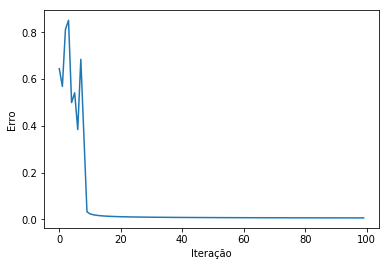

In [219]:
listaErros = []
#print(redeXOR.registroTreinamento[1][1][0][0])
for i in range(int(len(redeXOR.registroTreinamento)/100)):
    erros=[]
    for x in range(4):
        if x==0 or x==3:            
            erros.append(redeXOR.registroTreinamento[x*25+i*100][1][0][0])
        else:
            erros.append(redeXOR.registroTreinamento[x*25+i*100][1][0][0] - 1)
    listaErros.append(np.mean(np.abs(erros)))

plt.plot(listaErros)
plt.xlabel('Iteração')
plt.ylabel('Erro')
plt.show()

Percebe-se uma queda brusca no valor de erro em um espaço de tempo muito pequeno. Isto se deve possivelmente à função de ativação sigmoidal utilizada nos neurônios, juntamente com o fato de a taxa de aprendizagem ser relativamente alta.

# 4 Conclusão

É possível concluir que as redes neurais de múltiplas camadas conseguem aproximar funções que não são linearmente separáveis. O algoritmo de treinamento por *backpropagation* foi bastante efetivo para minimizar o erro, necessitando de apenas 10 iterações para alcançar o mínimo global. Foi observado que durante alguns processos de treinamento não houve redução do erro. Isto ocorreu devido à definição dos pesos inciais, demonstrando assim que os pesos iniciais devem ser considerados durante o processo de treinamento de uma rede neural.

Houve a necessidade de gerar mais amostras para o treinamento da rede neural, visto que o ajuste dos pesos utilizando poucas amostras para treinamento se mostrou bastante irregular, levando à erros na saída da rede frequentemente.